In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

In [51]:
c1 = 0.5 # now
c2 = 0.75 # in september
b = 1 # after september
h = 0.1

In [52]:
def cost(y, A, B):
    return b * (A+B) / 2 + (c1-b) * y - (b+h) * (A-y)*(A-y) / (2*(A-B))

def solve_second_exact(A, B):
    kappa = (b - c1) / (b + h)
    y = A * (1-kappa) + B * kappa
    c = cost(y, A, B)
    return y, c

def solve_second_MC(A, B, K):
    scenarios = np.random.uniform(low=A, high=B, size=K)

    y = cp.Variable(1)
    t = cp.Variable(K)
    objective = cp.Minimize(cp.sum(t) / K)
    constraints = [y >= 0]

    for i, dk in enumerate(scenarios):
        constraints.append((c1-b) * y - t[i] <= -b * dk)
        constraints.append((c1+h) * y - t[i] <= h * dk)
    
    prob = cp.Problem(objective, constraints)
    prob.solve()

    candidate = y.value[0]
    cost = prob.value
    return candidate, cost

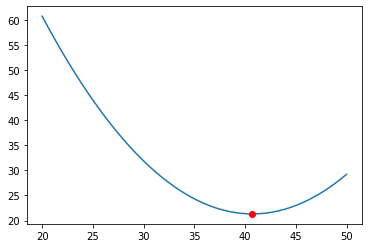

In [53]:
x = np.linspace(20, 50)
plt.plot(x, cost(x, 38, 44))
y, c = solve_second_exact(38, 44)
plt.plot(y, c, 'ro');

In [54]:
y1, cost1 = solve_second_MC(38, 44, 1000)
y2, cost2 = solve_second_exact(38, 44)
print(y1, cost1)
print(y2, cost2)

40.57866193144252 21.29862713832511
40.72727272727273 21.318181818181817


In [62]:
N = 100
K = 50

c2 = 0.6 # to check if the cost actually gets down

# samples ksi_i = (A_i, B_i) = (min(U_1, U_2), max(U_1, U_2)), where U_i ~ Uni[38, 44]
bounds = np.sort(np.random.uniform(low=38, high=44, size=(N,2)), axis=1)

# samples d_{i,j} ~ Uni[A_i, B_i]
bounds_K = np.repeat(bounds, K, axis=0)
d = np.random.uniform(low=bounds_K[:,0], high=bounds_K[:,1])
d = d.reshape((N, K))

x = cp.Variable(1)
t = cp.Variable((N, K))
y = cp.Variable(N)

objective = cp.Minimize(c1 * x + cp.sum(t) / (N*K))

constraints = [x >= 0]

for i in range(N):
    constraints.append(y[i] >= 0)
    for j in range(K):
        constraints.append((c2-b) * y[i] - t[i,j] <= -b * (d[i,j] - x))
        constraints.append((c2+h) * y[i] - t[i,j] <= h * (d[i,j] - x))

prob = cp.Problem(objective, constraints)
prob.solve()

candidate = x.value
cost = prob.value

print(candidate, cost)
print(np.mean(y.value))

[39.78580615] 20.934531872255334
1.115824528167892
